In [1]:
get_ipython().system_raw("unrar x data.rar")


In [2]:
images = []
labels = []

from skimage.io import imread
import os
root = 'data'

for root, dirs, files in os.walk(root):
    files.sort()
    if root.endswith('images'):
      for item in files:
        images.append(imread(os.path.join(root, item)))
    if root.endswith('labels'):
      for item in files:
        labels.append(imread(os.path.join(root, item)))

In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in labels]


import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
Y = Y[:,:,:,0]
print(f'Loaded {len(X)} images')
len(labels)

Loaded 20 images


20

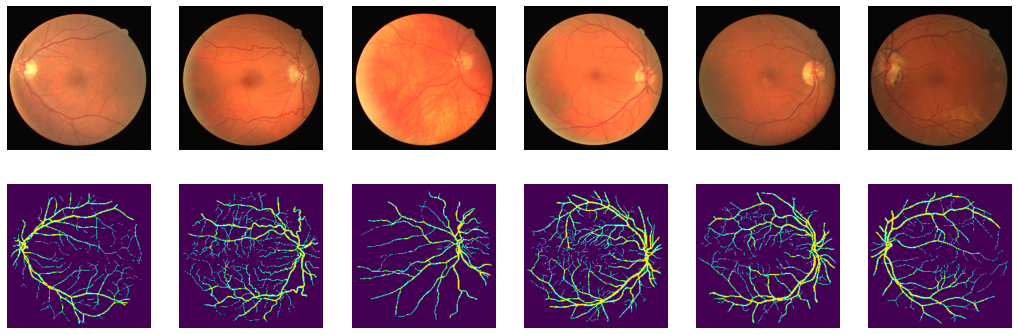

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [15, 20])
print(len(tr), len(val), len(ts))

15 5 0


In [6]:
from torch.utils.data import DataLoader
batch_size = 5 #25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [8]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))         
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  
    return thresholded 

In [9]:
def dice_loss(y_real, y_pred):
  smooth = 1*1e-5
  y_pred = torch.clamp (y_pred, smooth, 1-smooth )
  intersection =(y_real * y_pred).sum(dim = (1,2,3))
  union = (y_real + y_pred).sum(dim = (1,2,3))
  dice = 1 - (2. * intersection )/(union ) 
  return dice.mean()

In [10]:
def val_loss_score (model, loss_fn, score_fn, data_val): 
      loss_val = 0
      score_val = 0
      avg_loss_val = 0
      model.eval()
      with torch.no_grad():

          for X_batch, Y_batch in data_val:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) 

            Y_pred = model (X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            avg_loss_val += loss / len(data_val)
        
          loss_val = avg_loss_val
          score_val = score_model(model, score_fn, data_val)
      return loss_val, score_val

In [11]:
def train(model, opt, loss_fn, score_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    loss_train = []
    loss_val = []
    score_train = []
    score_val = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) 
            opt.zero_grad() 

            Y_pred = model (X_batch)
            loss = loss_fn(Y_batch, Y_pred) 
            loss.backward()  
            opt.step() 
            avg_loss += loss / len(data_tr)

        loss_train.append(avg_loss.detach().to('cpu')) 
        score_train.append(score_model(model, score_fn, data_tr)) 

        model.eval() 
        x_loss, x_score = val_loss_score (model, loss_fn, score_fn, data_val)
        loss_val.append(x_loss.detach().to('cpu')) 
        score_val.append(x_score) 
        toc = time()
        print('loss: %f' % avg_loss)

        model.eval()  

        Y_hat = model(X_val.to(device)).detach().to('cpu') 
        clear_output(wait=True)

        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 3, k+1+3)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return loss_train, loss_val , score_train, score_val

In [12]:
def predict(model, data):
    model.eval() 
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [13]:
def score_model(model, metric, data):
    model.eval() 
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device)) 
        Y_pred = torch.sigmoid(Y_pred) >0.5 
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
        iou_pytorch(Y_pred, Y_label.to(device))


    return scores/len(data)

In [14]:
k=1 

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

       # encoder (downsampling)
#0 ========== (0-6)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=64//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # 64x256x256
        self.enc_bn01 = nn.BatchNorm2d(64//k)
        
        self.enc_conv02 = nn.Conv2d(64//k, 64//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # 64x256x256
        self.enc_bn02 = nn.BatchNorm2d(64//k)
        self.enc_pool02 = nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
#1 ========== (7-13)
        self.enc_conv11 = nn.Conv2d(64//k, 128//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.enc_bn11 = nn.BatchNorm2d(128//k)
        
        self.enc_conv12 = nn.Conv2d(128//k, 128//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.enc_bn12 = nn.BatchNorm2d(128//k)
        self.enc_pool12 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
#2 ========== (14-23)
        self.enc_conv21 = nn.Conv2d(128//k, 256//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.enc_bn21 = nn.BatchNorm2d(256//k)
        
        self.enc_conv22 = nn.Conv2d(256//k, 256//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.enc_bn22 = nn.BatchNorm2d(256//k)
        self.enc_pool22 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
#3 ========== (24-33)
        self.enc_conv31 = nn.Conv2d(256//k, 512//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.enc_bn31 = nn.BatchNorm2d(512//k)
        
        self.enc_conv32 = nn.Conv2d(512//k, 512//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.enc_bn32 = nn.BatchNorm2d(512//k)
        self.enc_pool32 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
#4 ========== (34-43)
        self.enc_conv41 = nn.Conv2d(512//k, 1024//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.enc_bn41 = nn.BatchNorm2d(1024//k)

        self.enc_conv42 = nn.Conv2d(1024//k, 1024//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.enc_bn42 = nn.BatchNorm2d(1024//k)

        # decoder (upsampling) 
#3 ==========
        self.dec_upsample31 = nn.Upsample(32) # 16 -> 32
        self.dec_conv31 = nn.Conv2d(1024//k, 512//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    
        self.dec_conv32 = nn.Conv2d(1024//k, 512//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn32 = nn.BatchNorm2d(512//k)

        self.dec_conv33 = nn.Conv2d(512//k, 512//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn33 = nn.BatchNorm2d(512//k)
#2 ==========
        self.dec_upsample21 = nn.Upsample(64) # 32 -> 64
        self.dec_conv21 = nn.Conv2d(512//k, 256//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      
        self.dec_conv22 = nn.Conv2d(512//k, 256//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn22 = nn.BatchNorm2d(256//k)

        self.dec_conv23 = nn.Conv2d(256//k, 256//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn23 = nn.BatchNorm2d(256//k)
#1 ==========
        self.dec_upsample11 = nn.Upsample(128) # 64 -> 128
        self.dec_conv11 = nn.Conv2d(256//k, 128//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     
        self.dec_conv12 = nn.Conv2d(256//k, 128//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn12 = nn.BatchNorm2d(128//k)

        self.dec_conv13 = nn.Conv2d(128//k, 128//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn13 = nn.BatchNorm2d(128//k)
#0 ==========
        self.dec_upsample01 = nn.Upsample(256) # 128 -> 256
        self.dec_conv01 = nn.Conv2d(128//k, 64//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   
        self.dec_conv02 = nn.Conv2d(128//k, 64//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn02 = nn.BatchNorm2d(64//k)

        self.dec_conv03 = nn.Conv2d(64//k, 64//k, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn03 = nn.BatchNorm2d(64//k)

        self.dec_conv04 = nn.Conv2d(64//k, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.dec_bn04 = nn.BatchNorm2d(1)


    def forward(self, x):
        # encoder
#0 ==========
        e01 = F.relu (self.enc_bn01 (self.enc_conv01 (x)))
        e02 = F.relu (self.enc_bn02 ( self.enc_conv02(e01)))
        e03 = self.enc_pool02 (e02)
#1 ==========
        e11 = F.relu (self.enc_bn11 (self.enc_conv11(e03)))
        e12 = F.relu (self.enc_bn12 ( self.enc_conv12(e11)))
        e13 = self.enc_pool12 (e12)
#2 ==========
        e21 = F.relu (self.enc_bn21 (self.enc_conv21(e13)))
        e22 = F.relu (self.enc_bn22 ( self.enc_conv22(e21)))
        e23 = self.enc_pool22 (e22)
#3 ==========
        e31 = F.relu (self.enc_bn31 (self.enc_conv31(e23)))
        e32 = F.relu (self.enc_bn32 ( self.enc_conv32(e31)))
        e33 = self.enc_pool32 (e32)
      # bottleneck
#4 ==========
        e41 = F.relu (self.enc_bn41 (self.enc_conv41(e33)))
        e42 = F.relu (self.enc_bn42 (self.enc_conv42(e41)))

      # decoder
#3 ==========
        d31 = self.dec_upsample31(e42)
        d32 = self.dec_conv31(d31)
        d3_concat = torch.cat((e32, d32), dim=1)
        d33 = F.relu (self.dec_bn32 ( self.dec_conv32(d3_concat)))
        d34 = F.relu (self.dec_bn33 ( self.dec_conv33(d33)))
#2 ==========
        d21 = self.dec_upsample21(d34)
        d22 = self.dec_conv21(d21)
        d2_concat = torch.cat((e22, d22), dim=1)
        d23 = F.relu (self.dec_bn22 ( self.dec_conv22(d2_concat)))
        d24 = F.relu (self.dec_bn23 ( self.dec_conv23(d23)))
#1 ==========
        d11 = self.dec_upsample11(d24)
        d12 = self.dec_conv11(d11)
        d1_concat = torch.cat((e12, d12), dim=1)
        d13 = F.relu (self.dec_bn12 ( self.dec_conv12(d1_concat)))
        d14 = F.relu (self.dec_bn13 ( self.dec_conv13(d13)))
#0 ==========
        d01 = self.dec_upsample01(d14)
        d02 = self.dec_conv01(d01)
        d0_concat = torch.cat((e02, d02), dim=1)
        d03 = F.relu (self.dec_bn02 ( self.dec_conv02(d0_concat)))
        d04 = F.relu (self.dec_bn03 ( self.dec_conv03(d03)))
        d05 = self.dec_bn04 ( self.dec_conv04(d04)) 
        
        # print(d05.shape)
        return d05


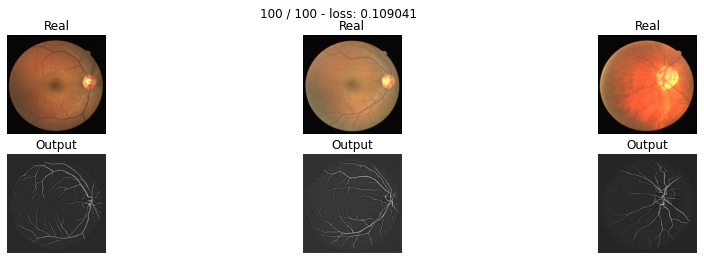

In [40]:
# model - Unet, loss - dice
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet().to(device)
max_epochs = 100
optim = torch.optim.AdamW(model.parameters(), lr=1*1e-4, weight_decay=0.001)
loss_train, loss_val, score_train, score_val = \
           train(model, optim, dice_loss, iou_pytorch, max_epochs, data_tr, data_val)



In [45]:
loss_train_Unet_dice = loss_train
loss_val_Unet_dice = loss_val
score_train_Unet_dice = score_train
score_val_Unet_dice = score_val

In [47]:
loss_train_Unet_dice = np.array(loss_train_Unet_dice).tolist()
loss_val_Unet_dice = np.array(loss_val_Unet_dice).tolist()
score_train_Unet_dice = np.array(score_train_Unet_dice).tolist()
score_val_Unet_dice = np.array(score_val_Unet_dice).tolist()

In [48]:
import pandas as pd 
data = {'loss_train': loss_train_Unet_dice, 'loss_val': loss_val_Unet_dice, 'score_train' : score_train_Unet_dice , 'score_val' : score_val_Unet_dice} 
df = pd.DataFrame(data) 
df


,loss_train,loss_val,score_train,score_val
0,0.778952,0.999980,0.000000,0.00
1,0.640270,0.999980,0.000000,0.00
2,0.549083,0.999980,0.000000,0.00
3,0.492867,0.999979,0.000000,0.00
4,0.448594,0.999963,0.000000,0.00
...,...,...,...,...
95,0.105047,0.268774,0.566667,0.14
96,0.103743,0.265493,0.520000,0.14
97,0.106012,0.270109,0.520000,0.14
98,0.103925,0.268113,0.500000,0.10
